In [113]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

rename_map = {
    # ===== Predict-then-Optimize baselines =====
    "LinearNNSoftmax_softmax_rolling_20251220_0149“maxreturn”": "Softmax-MaxReturn",
    "LinearNNSoftmax_softmax_rolling_20251222_1806“maxsharpe”": "Softmax-MaxSharpe",
    # ===== Robust SPO =====
    "LinearRobustSPO_linear_rolling_20251224_1830”RobustSPO, rho=0.01“": "RobustSPO (ρ=0.01)",
    "LinearRobustSPO_linear_rolling_20251227_1709“rho=0.1”": "RobustSPO (ρ=0.1)",
    # ===== SPO+ variants =====
    "LinearSPO+_linear_rolling_20251223_1614“markowitzPO”": "PtO Markowitz",
    "LinearSPO+_linear_rolling_20251224_2011“gamma=0.005”": "SPO+ with Fee (γ=0.005)",
    "LinearSPO+_linear_rolling_20251224_2311”gamma=0.005,lambda=0.42“": "SPO+ with turnover penalty(γ=0.005, λ=0.42)",
    # ===== Tuned SPO+ =====
    "LinearSPO+_rolling_optuna_20251220_0037": "SPO+",
}

In [114]:
# ===== 1. 设置你的父目录 =====
ROOT_DIR = r"D:\SPO4Portfolio\outputs"  # ← 改成你的路径

# 用来存每个实验的 nav 序列
nav_dict = {}

# ===== 2. 遍历所有子文件夹 =====
for exp_name in os.listdir(ROOT_DIR):
    exp_path = os.path.join(ROOT_DIR, exp_name)

    if not os.path.isdir(exp_path):
        continue

    csv_path = os.path.join(exp_path, "rolling_performance.csv")

    if not os.path.exists(csv_path):
        continue

    # ===== 3. 读取 rolling_performance.csv =====

    df = pd.read_csv(csv_path)

    # ===== 关键修复：兼容 Date / date =====
    if "Date" in df.columns:
        df["Date"] = pd.to_datetime(df["Date"])
        df = df.set_index("Date")
    elif "date" in df.columns:
        df["date"] = pd.to_datetime(df["date"])
        df = df.set_index("date")
    else:
        raise ValueError(f"{exp_name} 没有 Date/date 列")

    df.index = df.index.normalize()

    # 存入字典（key = 实验名，value = nav Series）
    nav_dict[exp_name] = df["nav"]

BASELINE_DIR = r"D:\SPO4Portfolio\outputs\Baselines"

for fname in ["MaxSharpe.csv"]:
    path = os.path.join(BASELINE_DIR, fname)

    df = pd.read_csv(path)

    if "date" in df.columns:
        df["date"] = pd.to_datetime(df["date"])
        df = df.set_index("date")
    df.index = df.index.normalize()
    key = os.path.splitext(fname)[0]  # EqualWeight / MaxSharpe
    nav_dict[key] = df["nav"]

# ===== 4. 合并成一个 DataFrame =====
nav_df = pd.concat(nav_dict, axis=1)
nav_df = nav_df.dropna(how="any")
nav_df = nav_df.rename(columns=rename_map)

display(nav_df)  # 如果在 Jupyter Notebook 中运行，可以看到表格

,Softmax-MaxReturn,Softmax-MaxSharpe,RobustSPO (ρ=0.01),RobustSPO (ρ=0.1),PtO Markowitz,SPO+ with Fee (γ=0.005),"SPO+ with turnover penalty(γ=0.005, λ=0.42)",SPO+,MaxSharpe
2016-01-05,0.990233,1.001032,0.990196,0.990196,1.002102,0.997398,0.997398,0.997398,0.987873
2016-01-06,0.974395,0.991854,0.974359,0.974359,0.993761,0.985096,0.985096,0.985096,0.975129
2016-01-07,0.969849,0.980598,0.969834,0.969834,0.975492,0.955997,0.955997,0.955997,0.956225
2016-01-08,0.965309,0.974594,0.965309,0.965309,0.968713,0.948427,0.948427,0.948427,0.947443
2016-01-11,0.938950,0.968249,0.938914,0.938914,0.969817,0.954577,0.954577,0.954577,0.945420
...,...,...,...,...,...,...,...,...,...
2024-12-23,1.382530,1.112095,2.113545,1.875368,2.042379,2.271909,1.860000,2.941338,1.751689
2024-12-24,1.386404,1.113168,2.115951,1.877503,2.052924,2.274494,1.877654,2.944686,1.763514
2024-12-26,1.393685,1.120882,2.117482,1.878861,2.056054,2.276140,1.876425,2.946816,1.764138
2024-12-27,1.391784,1.122702,2.113108,1.874980,2.048163,2.271439,1.858949,2.940729,1.752097


In [115]:
style_map = {
    "MaxSharpe": {
        "color": "#b08b57",  # light brown / sand
        "linestyle": "-",
        "linewidth": 1.6,
        "alpha": 0.8,
    },
    # ===== Predict-then-Optimize (cool colors) =====
    "Softmax-MaxReturn": {
        "color": "#1f77b4",  # deep blue
        "linestyle": "-",
        "linewidth": 2.1,
    },
    "Softmax-MaxSharpe": {
        "color": "#2ca9df",  # brighter cyan-blue
        "linestyle": "-",
        "linewidth": 2.1,
    },
    "PtO Markowitz": {
        "color": "#2ca02c",  # medium green
        "linestyle": "-",
        "linewidth": 2.1,
    },
    # ===== SPO family (warm / highlighted) =====
    "SPO+": {
        "color": "#d62728",  # strong red (main hero)
        "linestyle": "-",
        "linewidth": 2.1,
    },
    "SPO+ with Fee (γ=0.005)": {
        "color": "#6a51a3",  # deep purple (darker than before)
        "linestyle": "-",
        "linewidth": 2.1,
    },
    "SPO+ with turnover penalty(γ=0.005, λ=0.42)": {
        "color": "#c51b8a",  # deep magenta (more contrast vs purple)
        "linestyle": "-",
        "linewidth": 2.1,
    },
    "RobustSPO (ρ=0.01)": {
        "color": "#ff7f0e",  # strong orange
        "linestyle": "-",
        "linewidth": 2.9,
    },
    "RobustSPO (ρ=0.1)": {
        "color": "#fdae61",  # lighter orange (same family, diff strength)
        "linestyle": "-",
        "linewidth": 2.0,
    },
}

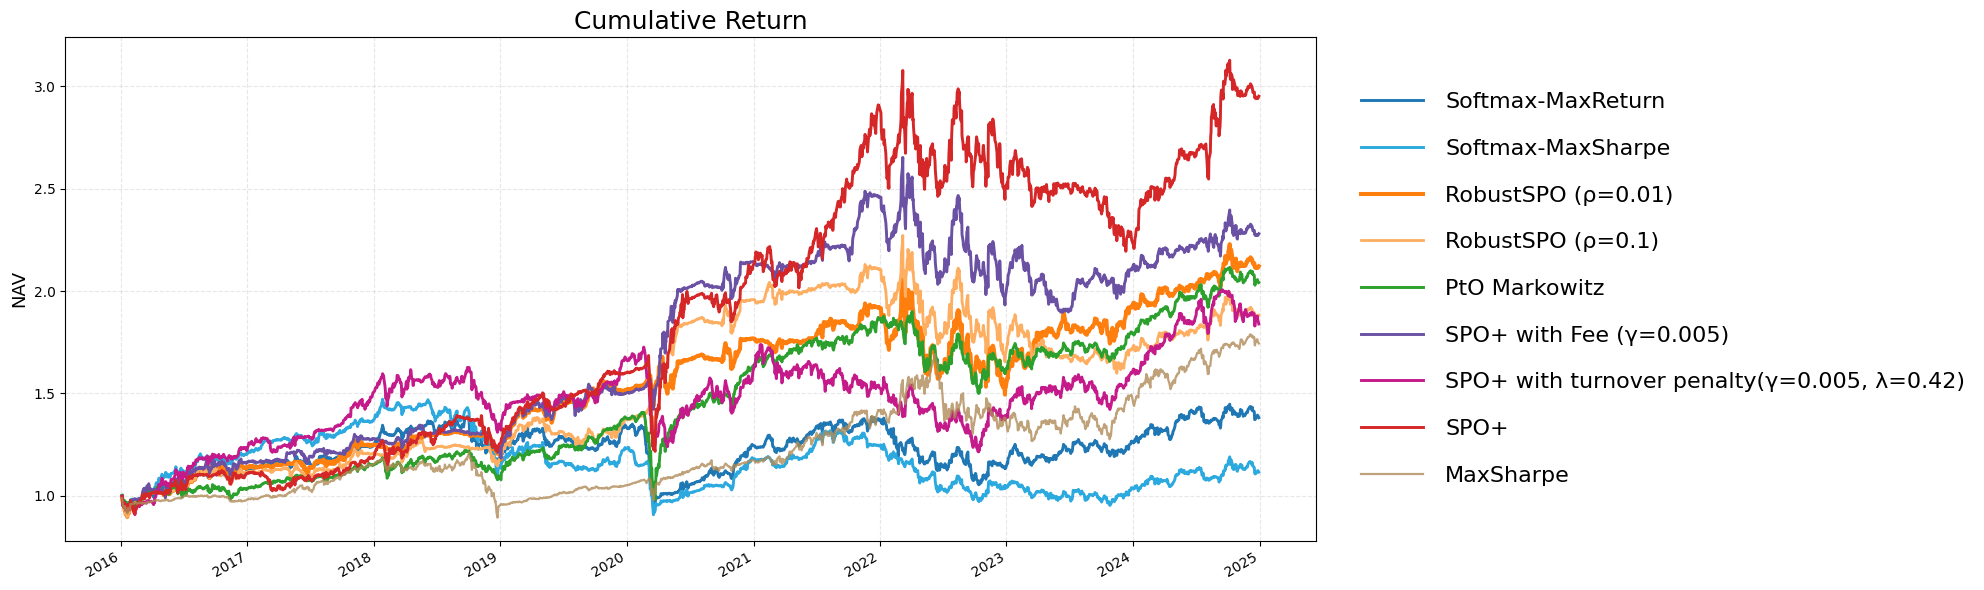

In [116]:
fig, ax = plt.subplots(figsize=(20, 6))

for col in nav_df.columns:
    style = style_map.get(col, {})
    nav_df[col].plot(ax=ax, label=col, **style)

ax.set_ylabel("NAV", fontsize=13)
ax.set_title("Cumulative Return", fontsize=18)
ax.grid(True, linestyle="--", alpha=0.3)

ax.legend(
    loc="center left",
    bbox_to_anchor=(1.02, 0.5),
    fontsize=16,
    frameon=False,
    labelspacing=1.2,  # ⭐ 标签上下间距（核心）
    handletextpad=1.0,  # 线和文字的距离
    handlelength=2.8,  # 线段长度
)

plt.tight_layout()
plt.show()

In [117]:
TRADING_DAYS = 252

# 日简单收益率
ret_df = nav_df.pct_change().dropna()
ret_df

,Softmax-MaxReturn,Softmax-MaxSharpe,RobustSPO (ρ=0.01),RobustSPO (ρ=0.1),PtO Markowitz,SPO+ with Fee (γ=0.005),"SPO+ with turnover penalty(γ=0.005, λ=0.42)",SPO+,MaxSharpe
2016-01-06,-0.015994,-0.009168,-0.015994,-0.015994,-0.008323,-0.012334,-0.012334,-0.012334,-0.012901
2016-01-07,-0.004665,-0.011349,-0.004644,-0.004644,-0.018384,-0.029539,-0.029539,-0.029539,-0.019386
2016-01-08,-0.004681,-0.006123,-0.004666,-0.004666,-0.006949,-0.007919,-0.007919,-0.007919,-0.009184
2016-01-11,-0.027306,-0.006511,-0.027344,-0.027344,0.001140,0.006485,0.006485,0.006485,-0.002134
2016-01-12,-0.006416,0.001439,-0.006426,-0.006426,0.006398,0.011896,0.011896,0.011896,0.003818
...,...,...,...,...,...,...,...,...,...
2024-12-23,0.006150,0.005282,-0.003094,-0.003094,0.002801,-0.003094,0.005926,-0.003094,0.002015
2024-12-24,0.002802,0.000965,0.001138,0.001138,0.005163,0.001138,0.009491,0.001138,0.006750
2024-12-26,0.005252,0.006929,0.000723,0.000723,0.001524,0.000723,-0.000655,0.000723,0.000354
2024-12-27,-0.001364,0.001625,-0.002065,-0.002065,-0.003838,-0.002065,-0.009313,-0.002065,-0.006825


In [118]:
def annualized_return(nav: pd.Series, trading_days=252):
    n_days = nav.shape[0]
    return (nav.iloc[-1] / nav.iloc[0]) ** (trading_days / n_days) - 1


def annualized_volatility(ret: pd.Series, trading_days=252):
    return ret.std() * np.sqrt(trading_days)


def sharpe_ratio(ret: pd.Series, trading_days=252, rf=0.0):
    excess_ret = ret - rf / trading_days
    return excess_ret.mean() / excess_ret.std() * np.sqrt(trading_days)


def sortino_ratio(ret: pd.Series, trading_days=252, rf=0.0):
    downside = ret[ret < 0]
    downside_std = np.sqrt((downside**2).mean())
    if downside_std == 0:
        return np.nan
    return (ret.mean() - rf / trading_days) / downside_std * np.sqrt(trading_days)


def max_drawdown(nav: pd.Series):
    cumulative_max = nav.cummax()
    drawdown = (nav - cumulative_max) / cumulative_max
    return drawdown.min()

In [119]:
results = []

for col in nav_df.columns:
    nav = nav_df[col].dropna()
    ret = ret_df[col].dropna()

    metrics = {
        "Strategy": col,
        "Annualized Return": annualized_return(nav),
        "Annualized Volatility": annualized_volatility(ret),
        "Sharpe Ratio": sharpe_ratio(ret),
        "Sortino Ratio": sortino_ratio(ret),
        "Max Drawdown": max_drawdown(nav),
    }
    results.append(metrics)

perf_df = pd.DataFrame(results).set_index("Strategy")
perf_df

,Annualized Return,Annualized Volatility,Sharpe Ratio,Sortino Ratio,Max Drawdown
Strategy,,,,,
Softmax-MaxReturn,0.041135,0.137540,0.362349,0.331147,-0.322040
Softmax-MaxSharpe,0.013206,0.130159,0.166223,0.152400,-0.383747
RobustSPO (ρ=0.01),0.096706,0.150871,0.687789,0.660148,-0.277931
RobustSPO (ρ=0.1),0.080935,0.149584,0.595283,0.582370,-0.296381
PtO Markowitz,0.090040,0.147560,0.658760,0.624260,-0.302212
SPO+ with Fee (γ=0.005),0.105378,0.157536,0.715072,0.698771,-0.285129
"SPO+ with turnover penalty(γ=0.005, λ=0.42)",0.076941,0.157388,0.550214,0.512222,-0.301808
SPO+,0.140509,0.190905,0.785126,0.728486,-0.287139
MaxSharpe,0.071278,0.136258,0.574045,0.513887,-0.263333
